# Face recognition using SVM and kernel trick

# Dataset description

This assignment asks you to build a classifier trained on face images. First, let's load the required dataset and see what it is. 

The table contains "straightened" representations of images of people's faces.

Initially, each image is a matrix of size $62 \times 47$ whose values are presumably normalized to a range $[0, 1]$ from the range $[0, 255] \cap \mathbb Z$. The values themselves are responsible for the intensity of the pixel: the larger the value, the lighter the pixel.

Note, from the image (or, what is the same thing, matrix) of size $62 \times 47$ we get a vector of $2914 = 62 \cdot 47$ length.

The column <code>label</code> is responsible for the name of the person depicted in the picture.

In [6]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('persons_pics_train.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,2905,2906,2907,2908,2909,2910,2911,2912,2913,label
0,0.379085,0.312418,0.352941,0.445752,0.466667,0.473203,0.484967,0.513725,0.545098,0.571242,...,0.597386,0.620915,0.732026,0.852288,0.921569,0.937255,0.941176,0.950327,0.946405,John Ashcroft
1,0.450980,0.466667,0.512418,0.509804,0.450980,0.458824,0.516340,0.571242,0.607843,0.618301,...,0.430065,0.453595,0.679739,0.934640,0.985621,0.981699,0.963399,0.938562,0.874510,Ariel Sharon
2,0.589542,0.614379,0.688889,0.729412,0.738562,0.775163,0.789543,0.806536,0.820915,0.837908,...,0.733333,0.854902,0.937255,0.624837,0.128105,0.082353,0.107190,0.095425,0.100654,Colin Powell
3,0.390850,0.432680,0.499346,0.562091,0.597386,0.644444,0.670588,0.650980,0.637908,0.639216,...,0.713726,0.898039,0.968627,0.959477,0.832680,0.443137,0.266667,0.303268,0.313725,Jean Chretien
4,0.645752,0.626144,0.605229,0.585621,0.602614,0.664052,0.701961,0.709804,0.733333,0.771242,...,0.115033,0.129412,0.132026,0.129412,0.155556,0.171242,0.167320,0.176471,0.183007,Colin Powell


Let's make sure that we actually see images of people's faces. Let's take the first $15$ rows from the initial dataframe and build the images corresponding to them.

In [3]:
import matplotlib.pyplot as plt

def get_img_by_row(row):
  return row.drop('label').astype(float).to_numpy().reshape(62,47), row['label']

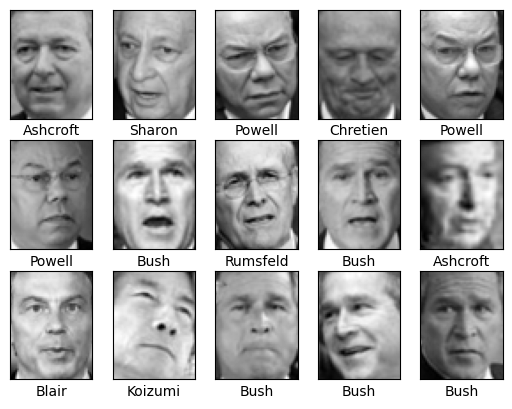

In [4]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    img, lbl = get_img_by_row(df.iloc[i])
    axi.imshow(img, cmap='gray')
    axi.set(xticks=[], yticks=[],
            xlabel=lbl.split()[-1])
plt.savefig('persons_pics_img_for_description.png', dpi = 300, bbox_inches='tight')    

Larger

(np.float64(-0.5), np.float64(46.5), np.float64(61.5), np.float64(-0.5))

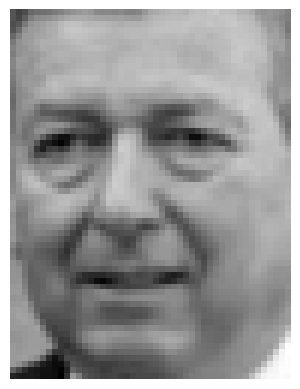

In [5]:
plt.imshow(df.iloc[0].drop('label').astype(float).to_numpy().reshape(62,47), cmap='gray')
plt.axis('off')

# A bit of mischief

Determine the number of different people whose pictures are contained in the dataset.

In [21]:
people = np.unique(df["label"])
np.size(people)


12

Construct a histogram of the distribution of objects by class and calculate the proportion of objects in each class.

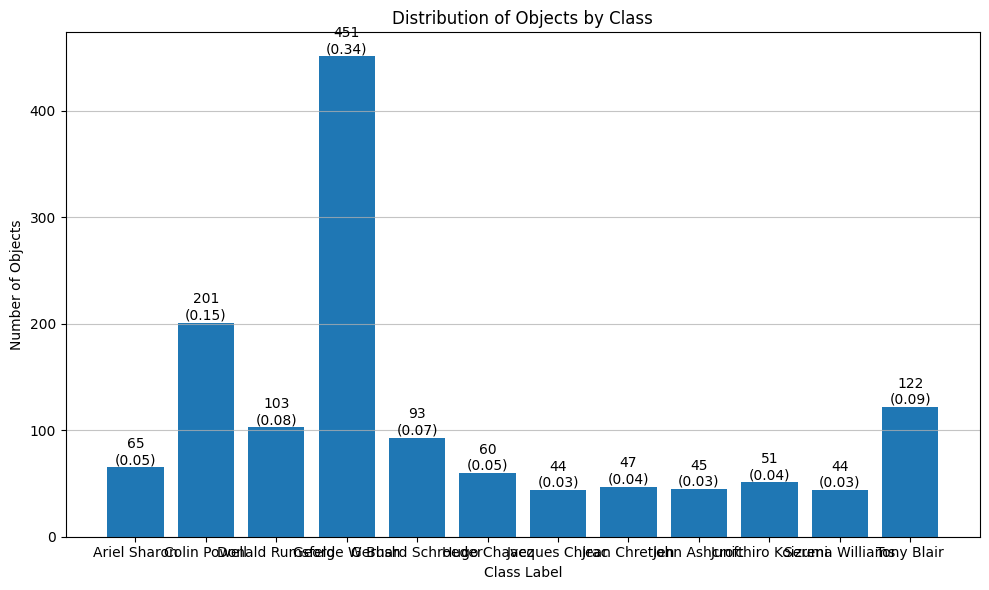

Class Proportions:
Class Ariel Sharon: 0.049
Class Colin Powell: 0.152
Class Donald Rumsfeld: 0.078
Class George W Bush: 0.340
Class Gerhard Schroeder: 0.070
Class Hugo Chavez: 0.045
Class Jacques Chirac: 0.033
Class Jean Chretien: 0.035
Class John Ashcroft: 0.034
Class Junichiro Koizumi: 0.038
Class Serena Williams: 0.033
Class Tony Blair: 0.092


In [25]:
def analyze_class_distribution_from_dataframe(df, label_column="label"):
    """
    Constructs a histogram of the distribution of objects by class and
    calculates the proportion of objects in each class from a pandas DataFrame.

    Args:
        df (pd.DataFrame): The pandas DataFrame containing the data.
        label_column (str): The name of the column that contains the class labels.
    """

    # 1. Get Labels from DataFrame Column
    labels = df[label_column]

    # Convert labels to string
    labels = labels.astype(str)

    # 2. Count Objects per Class
    unique_labels, counts = np.unique(labels, return_counts=True)

    # 3. Calculate Proportions
    proportions = counts / len(labels)

    # 4. Create Histogram
    plt.figure(figsize=(10, 6))
    plt.bar(unique_labels, counts, tick_label=unique_labels)
    plt.xlabel('Class Label')
    plt.ylabel('Number of Objects')
    plt.title('Distribution of Objects by Class')
    plt.xticks(unique_labels)
    plt.grid(axis='y', alpha=0.75)

    # Add Text Annotations
    for label, count, proportion in zip(unique_labels, counts, proportions):
        plt.text(label, count, f'{count}\n({proportion:.2f})', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    print("Class Proportions:")
    for label, prop in zip(unique_labels, proportions):
        print(f"Class {label}: {prop:.3f}")


analyze_class_distribution_from_dataframe(df, label_column="label")


Based on the available data, match each person with one vector whose coordinates are the average of the corresponding coordinates of all vectors identified with that person.

In [36]:
grouped_data = df.groupby("label").mean()
grouped_data #Junichiro Koizumi

,0,1,2,3,4,5,6,7,8,9,...,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913
label,,,,,,,,,,,,,,,,,,,,,
Ariel Sharon,0.501398,0.514811,0.532609,0.551714,0.569754,0.577456,0.581820,0.591835,0.604465,0.612589,...,0.396400,0.433947,0.478291,0.519920,0.532549,0.515656,0.498220,0.486657,0.466928,0.437687
Colin Powell,0.433512,0.441147,0.456248,0.471947,0.486730,0.513732,0.545157,0.566514,0.581556,0.592924,...,0.437869,0.471798,0.512067,0.534615,0.532176,0.510006,0.477586,0.448119,0.410659,0.379605
Donald Rumsfeld,0.404810,0.417260,0.442731,0.474028,0.507938,0.541659,0.560112,0.571838,0.585773,0.602386,...,0.494917,0.546837,0.562307,0.558627,0.549426,0.525947,0.500603,0.475550,0.431893,0.391738
George W Bush,0.348179,0.360263,0.381659,0.416669,0.457154,0.488335,0.515398,0.536075,0.551153,0.565662,...,0.385818,0.414092,0.441074,0.461325,0.470275,0.459067,0.447653,0.430523,0.399620,0.376584
Gerhard Schroeder,0.210162,0.228210,0.268255,0.328344,0.389332,0.447115,0.495003,0.527655,0.549441,0.569457,...,0.414969,0.430937,0.469281,0.494596,0.496718,0.482550,0.442252,0.428477,0.426875,0.411118
Hugo Chavez,0.206885,0.205142,0.240828,0.300806,0.370196,0.427712,0.471939,0.512702,0.545251,0.562070,...,0.337647,0.360523,0.372200,0.385926,0.394662,0.392309,0.384989,0.371503,0.372440,0.374052
Jacques Chirac,0.348010,0.368152,0.405704,0.436988,0.462686,0.498693,0.531135,0.553060,0.574629,0.594029,...,0.453832,0.469935,0.480957,0.486067,0.510933,0.537998,0.542751,0.505853,0.456625,0.434997
Jean Chretien,0.388958,0.412488,0.446614,0.487637,0.526158,0.563315,0.594827,0.628981,0.665026,0.685774,...,0.526380,0.574190,0.583452,0.555667,0.499764,0.455180,0.426060,0.415353,0.414713,0.397608
John Ashcroft,0.337894,0.334379,0.337662,0.357037,0.384779,0.397182,0.412375,0.431924,0.449441,0.466986,...,0.472651,0.468468,0.475759,0.489092,0.512999,0.540944,0.534524,0.524415,0.527495,0.527495


Enter the coordinate with index $0$ of the average vector corresponding to the person in your individual assignment.

In [81]:
0.268
grouped_data.index

df_no_label = df.drop("label", axis=1)
coordinates = list(df_no_label.columns.astype(str))
coordinates

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135',
 '136',
 '137',
 '138'

Using the average vectors, construct pictures of all the people in the dataset.

In [88]:
def average_vectors_by_person(df, person_id_column, vector_columns):
    """
    Matches each person with one vector whose coordinates are the average
    of the corresponding coordinates of all vectors identified with that person.

    Args:
        df (pd.DataFrame): A pandas DataFrame containing the data.
        person_id_column (str): The name of the column identifying each person.
        vector_columns (list of str): A list of column names containing the vector coordinates.

    Returns:
        pd.DataFrame: A new DataFrame with each person matched to their average vector.
    """

    # Group the DataFrame by the 'person_id_column'
    grouped_data = df.groupby(person_id_column)

    # Calculate the mean of the vectors coordinates of each person
    averaged_vectors = grouped_data[vector_columns].mean()

    # Create a new DataFrame with the averaged vectors
    averaged_df = pd.DataFrame(averaged_vectors)

    # Reset the index to make person_id_column a regular column again
    averaged_df = averaged_df.reset_index()
    
    return averaged_df

def visualize_average_vectors(df, image_shape, person_id_column="person_id", vector_columns = None):
    """
    Visualizes average vectors as images.

    Args:
        df (pd.DataFrame): DataFrame with averaged vectors.
        image_shape (tuple): Shape of the original images.
        person_id_column (str): The name of the column identifying each person.
        vector_columns (list of str): The name of the columns containing vector coordinates.
    """

    if not vector_columns:
       # if no vector columns are given, use all column besides person_id_column
      vector_columns = [col for col in df.columns if col != person_id_column]

    num_people = len(df)
    num_cols = 5  # Adjust for display purposes
    num_rows = (num_people + num_cols - 1) // num_cols # Calculate the number of rows that will be needed

    plt.figure(figsize=(num_cols * 2, num_rows * 2.5))

    for i, row in df.iterrows():
        person_id = row[person_id_column]
        average_vector = row[vector_columns].values.astype(float) # Ensure the data type is float

        # Check if the subplot index is within bounds before calling subplot
        if i+1 <= num_rows * num_cols:
           # Reshape and plot as image
           plt.subplot(num_rows, num_cols, i + 1)
           plt.imshow(average_vector.reshape(image_shape), cmap='gray')
           plt.title(f'{str(person_id)}')
           plt.axis('off')
        else:
             print(f"Skipping subplot for {person_id}, as its index is out of bounds")
             
    plt.tight_layout()
    plt.show()

df_vectors = average_vectors_by_person(df, "label", coordinates)


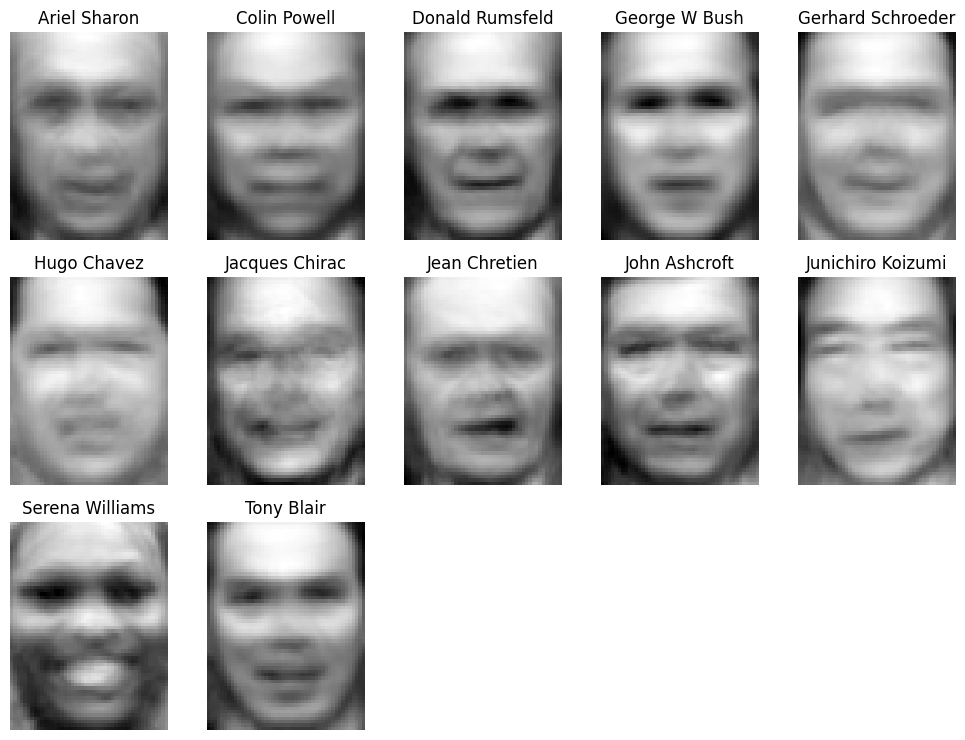

In [89]:
image_shape = (62, 47)
visualize_average_vectors(df_vectors, image_shape, "label", vector_columns = None)

The so-called [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) is often used as a measure of the "similarity" of two objects. It should not be confused with cosine distance.

Construct a similarity matrix of objects based on their averaged vectors. We recommend using a heat map for visualization, e.g. [from the seaborn library](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

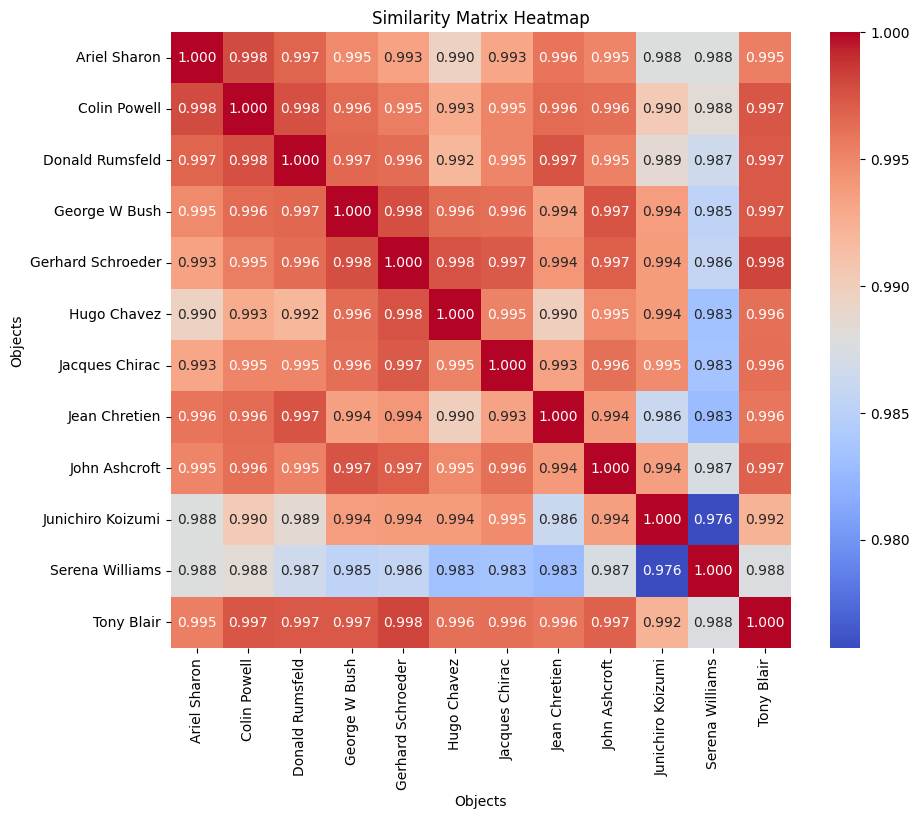

In [94]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
def construct_similarity_matrix(df, person_id_column="person_id", vector_columns=None, similarity_metric="cosine"):
    """
    Constructs a similarity matrix based on the averaged vectors and visualizes it with a heatmap.

    Args:
        df (pd.DataFrame): DataFrame with averaged vectors.
        person_id_column (str): Column containing person identifiers.
        vector_columns (list of str): Columns containing the vector coordinates.
        similarity_metric (str):  Metric for the similarity calculation.

    """
     # If no vector columns are provided, use all columns besides person_id_column
    if not vector_columns:
         vector_columns = [col for col in df.columns if col != person_id_column]

    # Get the averaged vectors
    averaged_vectors = df[vector_columns].values

    # Compute the similarity matrix
    if similarity_metric == "cosine":
       similarity_matrix = cosine_similarity(averaged_vectors)
    else:
       raise ValueError(f"Invalid similarity metric: {similarity_metric}")


    # Create a DataFrame for the heatmap (labels are person IDs)
    person_ids = df[person_id_column].values
    similarity_df = pd.DataFrame(similarity_matrix, index=person_ids, columns=person_ids)

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_df, annot=True, cmap="coolwarm", fmt=".3f")
    plt.title("Similarity Matrix Heatmap")
    plt.xlabel("Objects")
    plt.ylabel("Objects")
    plt.show()

construct_similarity_matrix(df_vectors, person_id_column="label", vector_columns=None, similarity_metric="cosine")

Determine the cosine similarity for a pair of people from your individual assignment based on their corresponding "average" vectors.

In [ ]:
#Colin Powell and Gerhard Schroeder, 0.995

# Построение модели

Use <code>train_test_split()</code> to split the dataset into training and test samples with the parameters from your individual assignment. Use stratification by column <code>label</code>.

In [98]:
from sklearn.model_selection import train_test_split
X = df_no_label
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9, stratify=y)

## First approximation: a basic SVM classifier with a linear kernel

Train the <code>SVC()</code> model on the training dataset with the parameters from your individual assignment.

In [ ]:
from sklearn.svm import SVC
model = SVC(kernel='linear', random_state=9)
model.fit(X_train, y_train)

SVC(kernel='linear', random_state=9)

Evaluate the model on test dataset. Compute <code>f1_score(average='weighted')</code>.

In [101]:
from sklearn.metrics import f1_score
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
f1

np.float64(0.7987016487207418)

Overall, a pretty good result, but it makes sense to try to tweak the parameters.

## Selection of hyperparameters

Using <code>GridSearchCV()</code>, perform a hyperparameter selection based on the values from your individual assignment. Observe the training time of the models.

In [103]:
from sklearn.model_selection import GridSearchCV
tuned_parameters = [{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000], 'class_weight': [None, 'balanced'], 'random_state':[9]}]


cv = GridSearchCV(SVC(), tuned_parameters, refit=True, verbose=3)

Determine the parameters of the <b>best</b> learned model.

In [104]:
cv.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=9;, score=0.802 total time=   2.4s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=9;, score=0.708 total time=   2.1s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=9;, score=0.821 total time=   1.9s
[CV 4/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=9;, score=0.792 total time=   2.1s
[CV 5/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=9;, score=0.774 total time=   2.0s
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=9;, score=0.363 total time=   2.5s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=9;, score=0.373 total time=   2.7s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=9;, score=0.373 total time=   2.6s
[CV 4/5] END C=1, class_weight=None, gam

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'class_weight': [None, 'balanced'],
                          'gamma': [0.001, 0.0001],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                          'random_state': [9]}],
             verbose=3)

Perform prediction for the test dataset using the best model obtained. Compute <code>f1_score(average='weighted')</code>.

In [106]:
cv.best_params_

{'C': 100,
 'class_weight': 'balanced',
 'gamma': 0.001,
 'kernel': 'rbf',
 'random_state': 9}

In [109]:
model_best = SVC(kernel='rbf', random_state=9, C=100, gamma=0.001, class_weight="balanced")
model_best.fit(X_train, y_train)
y_pred_best = model_best.predict(X_test)
f1_best = f1_score(y_test, y_pred_best, average='weighted')
f1_best

np.float64(0.809660918360865)

## Dimensionality reduction

Learning took a long time. It makes sense to test what happens if you reduce the dimensionality of the input dataset, e.g. by using <code>PCA</code>. Train the <code>PCA(svd_solver='full')</code> model on the training dataset and determine the minimum number of components required for the explained variance ratio to be greater than <code>0.95</code>.

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(svd_solver='full')

 # Fit PCA on scaled training data
pca.fit(X_train, y_train)

    # Calculate cumulative explained variance ratio
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Find the index where cumulative variance exceeds the threshold
num_components = np.argmax(cumulative_variance >= 0.95) + 1
num_components

np.int64(173)

Re-train the <code>PCA(svd_solver='full')</code> model on the training dataset using the resulting number of principal components. Apply the resulting transformation to the training and test datasets.

In [123]:
pca = PCA(svd_solver='full', n_components=173)
pca.fit(X_train, y_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train.shape, "\n", X_train_pca.shape)

(1060, 2914) 
 (1060, 173)


For the data obtained after <code>PCA</code>, similarly to what was done earlier, i.e., using the <code>GridSearchCV()</code>, select hyperparameters from the ranges specified in your individual assignment. Pay special attention to model training time.

In [119]:
cv = GridSearchCV(SVC(), tuned_parameters, refit=True, verbose=3)
cv.fit(X_train_pca, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=9;, score=0.769 total time=   0.1s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=9;, score=0.684 total time=   0.0s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=9;, score=0.807 total time=   0.0s
[CV 4/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=9;, score=0.792 total time=   0.0s
[CV 5/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=9;, score=0.745 total time=   0.0s
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=9;, score=0.344 total time=   0.0s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=9;, score=0.340 total time=   0.0s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=9;, score=0.340 total time=   0.0s
[CV 4/5] END C=1, class_weight=None, gam

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'class_weight': [None, 'balanced'],
                          'gamma': [0.001, 0.0001],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                          'random_state': [9]}],
             verbose=3)

Determine the parameters of the <b>best</b> model obtained.

In [120]:
cv.best_params_

{'C': 100,
 'class_weight': 'balanced',
 'gamma': 0.001,
 'kernel': 'rbf',
 'random_state': 9}

Perform prediction for the test dataset using the best model obtained. Compute <code>f1_score(average='weighted')</code>.

In [128]:
model_pca = SVC(kernel='rbf', random_state=9, C=100, gamma=0.001, class_weight="balanced")
model_pca.fit(X_train_pca, y_train)
y_pred_pca = model_pca.predict(X_test_pca)
f1_pca = f1_score(y_test, y_pred_pca, average='weighted')
f1_pca

np.float64(0.7887387141091253)

In [126]:
X_test_pca.shape

(266, 173)

It can be seen that the quality of the model has changed only slightly, while the training time has decreased significantly.